# napari

In [1]:
import numpy as np
import napari
import copy
from napari.layers.utils.stack_utils import images_to_stack
import pickle
import nest_asyncio
nest_asyncio.apply()
import torch
import torchvision
import timm
from pathml.core import HESlide
from sklearn.decomposition import PCA
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE
import csv

In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The text.latex.preview rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In C:\Users\lhy\AppData\Local\Continuum\anaconda3\envs\pathml1\lib\site-packages\matplotlib\mpl-data\stylelib\_classic_test.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.

In [8]:
def generate_pca_image(row,matrix,point_size):
    #print(matrix[0:10])
    matrix_min=np.min(matrix,axis=0)
    matrix=matrix-np.min(matrix,axis=0)
    matrix_max=np.max(matrix,axis=0)
    col=int(row*matrix_max[1]/matrix_max[0])
    plot_matrix=np.ones((row,col,3),dtype='uint8')*255
    min_col=0.05*col
    min_row=0.05*row
    max_row=0.95*row
    max_col=0.95*col
    matrix[:,0]=min_row+matrix[:,0]*(max_row-min_row)/matrix_max[0]
    matrix[:,1]=min_col+matrix[:,1]*(max_col-min_col)/matrix_max[1]
    matrix=matrix.astype(int)
    for i in range(matrix.shape[0]):
        plot_matrix[matrix[i,0]:matrix[i,0]+point_size,matrix[i,1]:matrix[i,1]+point_size,:]=0
    #print(plot_matrix.shape)
    return plot_matrix,min_col,min_row,max_row,max_col,matrix_min,matrix_max

In [9]:
def generate_pca_point(row,matrix,point_size):
    #print(matrix[0:10])
    matrix_min=np.min(matrix,axis=0)
    matrix=matrix-np.min(matrix,axis=0)
    matrix_max=np.max(matrix,axis=0)
    col=int(row*matrix_max[1]/matrix_max[0])
    plot_matrix=np.ones((row,col,3),dtype='uint8')*255
    min_col=0.05*col
    min_row=0.05*row
    max_row=0.95*row
    max_col=0.95*col
    matrix[:,0]=min_row+matrix[:,0]*(max_row-min_row)/matrix_max[0]
    matrix[:,1]=min_col+matrix[:,1]*(max_col-min_col)/matrix_max[1]
    matrix=matrix.astype(int)
    width=max(int(min(row,col)*0.002),1)
    row_interval=int(row/4)
    col_interval=int(col/4)
    color=220
    for i in range(1,4):
        plot_matrix[i*row_interval:i*row_interval+width,:]=color
    for i in range(1,4):
        plot_matrix[:,i*col_interval:i*col_interval+width,:]=color
    return plot_matrix,matrix,min_col,min_row,max_row,max_col,matrix_min,matrix_max

In [10]:
def transform_point(matrix,min_col,min_row,max_row,max_col,matrix_min,matrix_max):
    matrix=matrix-matrix_min
    matrix[:,0]=min_row+matrix[:,0]*(max_row-min_row)/matrix_max[0]
    matrix[:,1]=min_col+matrix[:,1]*(max_col-min_col)/matrix_max[1]
    matrix=matrix.astype(int)
    return matrix

In [11]:
def transform_clickpos(x,y,row,col,orig_row,orig_col,plot_col):
    x1=x
    y1=y-plot_col
    x1=int(x1*orig_row/row)
    y1=int(y1*orig_col/col)
    return x1,y1

In [12]:
MODEL_PATH = 'C:/harvard/capstone/tenpercent_resnet18.ckpt'
def load_model_weights(model, weights):

    model_dict = model.state_dict()
    weights = {k: v for k, v in weights.items() if k in model_dict}
    if weights == {}:
        print('No weight could be loaded..')
    model_dict.update(weights)
    model.load_state_dict(model_dict)

    return model

model1 = torchvision.models.__dict__['resnet18'](pretrained=False)

state = torch.load(MODEL_PATH, map_location=torch.device('cpu'))

state_dict = state['state_dict']
for key in list(state_dict.keys()):
    state_dict[key.replace('model.', '').replace('resnet.', '')] = state_dict.pop(key)

model1 = load_model_weights(model1, state_dict)
model1.fc = torch.nn.Sequential()

In [13]:
def readincoord(file_path):
    coord=[]
    with open(file_path) as file:
        reader=csv.reader(file)
        for i in reader:
            coord.append(i)
    coord=np.array(coord,dtype=int)
    coord=[list(coord[i]) for i in range(coord.shape[0])]
    return coord

In [14]:
class embedding():
    def __init__(self,emb,coord,idx):
        self.emb=emb
        self.coord=coord
        self.idx=idx

In [15]:
def comp_coords(x1,y1,embeds,idx,tile_size):
    x2=embeds[idx].coord[0][0]
    y2=embeds[idx].coord[0][1]
    if x1>=x2 and x1-x2<tile_size:
        if y1>=y2 and y1-y2<tile_size:
            return "e"
        elif y1>=y2+tile_size:
            return "g"
        else:
            return 'l'
    elif x1>=x2+tile_size:
        return "g"
    else:
        return "l"
def binary_search(x,y,embeds,tile_size):
    s=0
    e=len(embeds)-1
    while s<=e:
        m=int((s+e)/2)
        media=comp_coords(x,y,embeds,m,tile_size)
        if media=='e':
            return embeds[m]
        elif media=='g':
            s=m+1
        else:
            e=m-1
    return None

In [129]:
#m = timm.create_model('xception41', pretrained=True,num_classes = 0)
wsi = HESlide("C:/harvard/capstone/small_HE.svs", name = "example")
thumbnail = wsi.slide.get_thumbnail(size = (5000, 5000))
viewer = napari.Viewer()
viewer.grid.enabled=True
layer1=viewer.add_image(thumbnail)
point_size=int(0.005*layer1.data.shape[0])
with open("C:/harvard/capstone/pca_model2.pickle",'rb') as f:
    pca_model=pickle.load(f)
with open("C:/harvard/capstone/tile_pca2.npy", 'rb') as f:
    pca_matrix = np.load(f)
layer2_data,min_col,min_row,max_row,max_col,matrix_min,matrix_max=generate_pca_image(layer1.data.shape[0],pca_matrix,point_size)
#layer2_data,point_matrix,min_col,min_row,max_row,max_col,matrix_min,matrix_max=generate_pca_point(layer1.data.shape[0],pca_matrix,point_size)
layer2=viewer.add_image(layer2_data)
layer2_data_orig=copy.deepcopy(layer2_data)
tile_size=64
coords=readincoord("C:/harvard/capstone/coordinates.csv")
embeds=[embedding(pca_matrix[i:i+1],coords[i]) for i in range(len(coords))]
embeds.sort(key=lambda x:x.coord)
@layer1.mouse_double_click_callbacks.append
def update_layer(layer, event):
    position=event.position
    """
    result=None
    row_s=int(min(position[0],row-size))
    col_s=int(min(position[1]-layer2_data_orig.shape[1],col-size))
    print((row_s,col_s))
    row_e=row_s+size
    col_e=col_s+size
    result=[]
    for i in range(row_s,row_e):
        media=[]
        for j in range(col_s,col_e):
            media.append(list(layer1.get_value((i,j))))
        result.append(media)
    result=np.array(result)
    print(result[0:5,0:5])
    """
    result=None
    pos_x,pos_y=transform_clickpos(position[0],position[1],layer1.data.shape[0],layer1.data.shape[1],wsi.shape[0],wsi.shape[1],layer2_data_orig.shape[1])
    result=binary_search(pos_x,pos_y,embeds,tile_size)
    if result is not None:
        #tile_tensor=torch.tensor(result,dtype=torch.float)
        #tile_tensor=tile_tensor.permute(2,1,0)
        #tile_tensor=tile_tensor.unsqueeze(0)
        #model1.eval()
        #output=model1(tile_tensor)
        #output=output.reshape(1,-1).detach().numpy()
        #print(output)
        #output=pca_model.transform(output)
        #print(output)
        output=transform_point(result,min_col,min_row,max_row,max_col,matrix_min,matrix_max)
        x=int(output[0,0])
        y=int(output[0,1])
        #print((x,y))
        layer2_data1=copy.deepcopy(layer2_data_orig)
        layer2_data1[x:x+point_size*2,y:y+point_size*2]=255
        layer2_data1[x:x+point_size*2,y:y+point_size*2,1:3]=0
        layer2.data=layer2_data1
    else:
        print("no embedding for the tile")
napari.run()

In [16]:
wsi = HESlide("C:/harvard/capstone/small_HE.svs", name = "example")
thumbnail = wsi.slide.get_thumbnail(size = (5000, 5000))
"""
with open("C:/harvard/capstone/pca_model_filter.pickle",'rb') as f:
    pca_model=pickle.load(f)
"""
with open("C:/harvard/capstone/tile_pca_filter.npy", 'rb') as f:
    pca_matrix = np.load(f)
point_size=int(0.005*thumbnail.shape[0])
layer2_data,point_matrix,min_col,min_row,max_row,max_col,matrix_min,matrix_max=generate_pca_point(thumbnail.shape[0],pca_matrix,point_size)
viewer = napari.Viewer()
#viewer.grid.enabled=True
layer1=viewer.add_image(np.concatenate((layer2_data,thumbnail),axis=1))
layer2=viewer.add_points(point_matrix,size=point_size,properties={'label':kmean.labels_},edge_color='label',edge_color_cycle=['green','blue','orange','black','purple'])
layer3=viewer.add_points(point_matrix[0:1],size=point_size*3,symbol='cross',opacity=0,edge_color='red',face_color='red')
tile_size=64
coords=readincoord("C:/harvard/capstone/filter_coords.csv")
embeds=[embedding(pca_matrix[i:i+1],coords[i:i+1],i) for i in range(len(coords))]
embeds.sort(key=lambda x:x.coord)
@layer1.mouse_double_click_callbacks.append
def update_layer(layer, event):
    position=event.position
    result=None
    pos_x,pos_y=transform_clickpos(position[0],position[1],thumbnail.shape[0],thumbnail.data.shape[1],wsi.shape[0],wsi.shape[1],layer2_data.shape[1])
    result=binary_search(pos_x,pos_y,embeds,tile_size)
    if result is not None:
        layer3.opacity=1.0
        x=int(layer2.data[result.idx,0])
        y=int(layer2.data[result.idx,1])
        print(result.idx)
        layer3.data=np.array([[x,y]],dtype=int)
    else:
        layer3.opacity=0.0
        print("no embedding for the tile")
napari.run()

# pca_test

In [3]:
import csv
import numpy as np
tile_ma=[]
with open("C:/harvard/capstone/tilefeatures2_eval3.csv") as file:
    reader=csv.reader(file)
    for i in reader:
        tile_ma.append(i)
tissue_masks=[]
with open("C:/harvard/capstone/tissue_masks.csv") as file:
    reader=csv.reader(file)
    for i in reader:
        tissue_masks.append(int(i[0]))
tile_ma=tile_ma[1:]
tile_ma=[tile_ma[i] for i in range(len(tile_ma)) if tissue_masks[i]>0]
tile_ma=np.array(tile_ma,dtype=float)

In [26]:
from sklearn.decomposition import PCA
pca = PCA(n_components=100)
pca.fit(tile_ma)

PCA(n_components=100)

In [5]:
import matplotlib.pyplot as plt
plt.plot(pca.explained_variance_ratio_)

NameError: name 'pca' is not defined

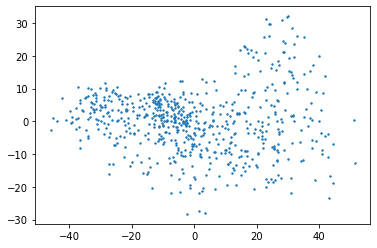

In [28]:
tile_pca=pca.transform(tile_ma)
tile_pca=tile_pca[:,0:2]
plt.scatter(tile_pca[:,0],tile_pca[:,1],marker='o',s=2)

In [18]:
tile_pca[0]

array([-16.51741812,  -3.5404986 ])

In [19]:
pca_model.transform(tile_ma[0:1])

array([[-76.57956389,  22.04613157]])

## Cluster

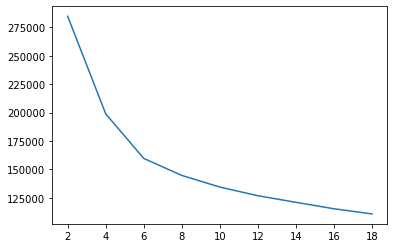

In [6]:
from sklearn.cluster import KMeans
inerts=[]
x=[]
for i in range(2,20,2):
    x.append(i)
    kmean=KMeans(n_clusters=i, random_state=0).fit(tile_ma)
    inerts.append(kmean.inertia_)
plt.plot(x,inerts)

In [7]:
kmean=KMeans(n_clusters=5, random_state=0).fit(tile_ma)
#kmean.labels_

# fit pca model

In [18]:
import csv
import numpy as np
from sklearn.decomposition import PCA
import pickle
tile_ma=[]
with open("C:/harvard/capstone/tilefeatures2_eval6.csv") as file:
    reader=csv.reader(file)
    for i in reader:
        tile_ma.append(i)
tissue_masks=[]
with open("C:/harvard/capstone/tissue_masks.csv") as file:
    reader=csv.reader(file)
    for i in reader:
        tissue_masks.append(int(i[0]))
coords=readincoord("C:/harvard/capstone/coordinates.csv")
tile_ma=tile_ma[1:]
assert len(coords)==len(tissue_masks)
assert len(tile_ma)==len(tissue_masks)
tile_ma=[tile_ma[i] for i in range(len(tile_ma)) if tissue_masks[i]>0]
coords=[coords[i] for i in range((len(coords))) if tissue_masks[i]>0]
tile_ma=np.array(tile_ma,dtype=float)
pca = PCA(n_components=2)
tile_pca=pca.fit_transform(tile_ma)
with open('C:/harvard/capstone/tile_pca_filter1.npy', 'wb') as f:
    np.save(f, tile_pca)
import pickle
import csv
with open("C:/harvard/capstone/pca_model_filter1.pickle",'wb') as f:
    pickle.dump(pca,f)
with open("C:/harvard/capstone/filter_coords1.csv",'w',newline='') as f:
    csv_writer=csv.writer(f)
    csv_writer.writerows(coords)

In [29]:
coords

[[1024, 1024],
 [1024, 1088],
 [1024, 1152],
 [1024, 1216],
 [1024, 1280],
 [1024, 1344],
 [1024, 1408],
 [1024, 1472],
 [1024, 1536],
 [1024, 1600],
 [1024, 1664],
 [1024, 320],
 [1024, 384],
 [1024, 448],
 [1024, 512],
 [1024, 576],
 [1024, 640],
 [1024, 704],
 [1024, 768],
 [1024, 832],
 [1024, 896],
 [1024, 960],
 [1088, 1024],
 [1088, 1088],
 [1088, 1152],
 [1088, 1216],
 [1088, 128],
 [1088, 1280],
 [1088, 1344],
 [1088, 1408],
 [1088, 1472],
 [1088, 1536],
 [1088, 1664],
 [1088, 1728],
 [1088, 1792],
 [1088, 192],
 [1088, 256],
 [1088, 320],
 [1088, 384],
 [1088, 448],
 [1088, 768],
 [1088, 832],
 [1088, 896],
 [1088, 960],
 [1152, 1024],
 [1152, 1088],
 [1152, 1152],
 [1152, 1216],
 [1152, 1280],
 [1152, 1344],
 [1152, 1408],
 [1152, 1472],
 [1152, 1536],
 [1152, 1664],
 [1152, 1728],
 [1152, 832],
 [1152, 896],
 [1152, 960],
 [1216, 1024],
 [1216, 1088],
 [1216, 1152],
 [1216, 1216],
 [1216, 1280],
 [1216, 1344],
 [1216, 1408],
 [1216, 1472],
 [1216, 1536],
 [1216, 1664],
 [12

In [33]:
with open("C:/harvard/capstone/pca_model.pickle",'rb') as f:
    pca1=pickle.load(f)

In [9]:
wsi = HESlide("C:/harvard/capstone/small_HE.svs", name = "example")

In [10]:
from pathml.preprocessing import Pipeline, BoxBlur, TissueDetectionHE

pipeline = Pipeline([
    BoxBlur(kernel_size=4),
])
wsi.run(pipeline, distributed=False,tile_size = 64)

In [11]:
wsi

SlideData(name='example',
	slide_type=SlideType(stain=HE, platform=None, tma=None, rgb=True, volumetric=None, time_series=None),
	filepath='C:/harvard/capstone/small_HE.svs',
	backend='openslide',
	image shape: (2967, 2220),
	1564 tiles: ['(0, 0)', '(0, 1024)', '(0, 1088)', '(0, 1152)', '(0, 1216)', '(0, 128)', ...],
	0 masks: [],
	tile_shape=(64, 64, 3),
	labels=None,
	counts=None)

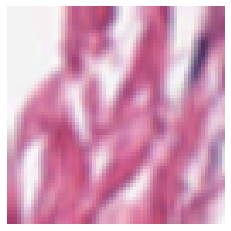

In [12]:
import matplotlib.pyplot as plt
media=wsi.tiles[811].image
media=media.astype(int)
plt.axis('off')
plt.imshow(media)

In [76]:
media

array([[[212., 183., 203.],
        [213., 183., 204.],
        [215., 187., 206.],
        ...,
        [246., 243., 243.],
        [246., 243., 243.],
        [246., 243., 243.]],

       [[213., 184., 205.],
        [214., 185., 206.],
        [216., 189., 207.],
        ...,
        [246., 243., 243.],
        [246., 243., 243.],
        [246., 243., 243.]],

       [[214., 187., 206.],
        [214., 187., 207.],
        [216., 191., 209.],
        ...,
        [246., 243., 243.],
        [246., 243., 243.],
        [246., 243., 243.]],

       ...,

       [[242., 243., 243.],
        [241., 243., 243.],
        [241., 242., 243.],
        ...,
        [246., 243., 243.],
        [246., 243., 243.],
        [246., 243., 243.]],

       [[241., 243., 243.],
        [241., 243., 243.],
        [240., 242., 243.],
        ...,
        [246., 243., 243.],
        [246., 243., 243.],
        [246., 243., 243.]],

       [[241., 243., 243.],
        [240., 243., 243.],
        [240., 2